In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [43]:
data = pd.read_csv(r'C:\Users\giuli\Documents\GitHub\Progetto_BI2021\data.csv', parse_dates=['created_at'])
df = pd.DataFrame(data)

## DECODING DEL TESTO ALL INTERNO DELLA COLONNA `text`. 
All interno della colonna text è presente una rappresentazione di un bytes sotto forma di stringa. Questa può essere valutata attraverso la funzione `ast.literal_eval(string)` e quindi decodificata
#secondo la codifica appropriata tramite il metodo decode

In [44]:
text_enc = []
for i in range(0, df.text.size):
    txt= ast.literal_eval(df.text[i]).decode('utf-8')
    text_enc.append(txt)

df['text_enc'] = text_enc
df

,favorite_count,source,text,is_retweet,created_at,retweet_count,text_enc
0,1,Twitter for Android,b'La #monarqu\xc3\xada se burla a diario de lo...,False,2021-03-03 07:46:48+00:00,0,La #monarquía se burla a diario de los español...
1,0,Twitter for iPhone,b'@TitusNation the CON serving CONservative GO...,False,2021-03-03 17:22:21+00:00,0,@TitusNation the CON serving CONservative GOP ...
2,0,Twitter for Android,b'#Coronavirus\nAustria and Denmark are to sto...,False,2021-03-03 08:47:26+00:00,0,#Coronavirus\nAustria and Denmark are to stop ...
3,0,Twitter Web App,b'BMC launches \xe2\x80\x98Mission Zero\xe2\x8...,False,2021-03-01 12:23:57+00:00,0,BMC launches ‘Mission Zero’ in Mumbai again to...
4,0,Twitter for iPhone,b'@Gadaffyduck @IsabelOakeshott @AmandaHolden ...,False,2021-03-04 20:49:11+00:00,0,@Gadaffyduck @IsabelOakeshott @AmandaHolden Du...
...,...,...,...,...,...,...,...
4163,4,Tweetbot for Mac,"b'In other news, I have been jabbed with the f...",False,2021-03-02 19:18:52+00:00,0,"In other news, I have been jabbed with the fir..."
4164,5,Twitter Web App,"b""So nearly 10% of today's new cases are the n...",False,2021-03-04 22:56:28+00:00,4,So nearly 10% of today's new cases are the new...
4165,2,Twitter for Android,"b""Read this\n\nThen read it again\n\nWritten, ...",False,2021-03-04 07:46:47+00:00,1,"Read this\n\nThen read it again\n\nWritten, pr..."
4166,8,Twitter Web App,b'\xe2\x80\xbc\xef\xb8\x8fUpdate\xe2\x80\xbc\x...,False,2021-03-04 12:39:09+00:00,4,‼️Update‼️ Individuals who file an IRS Form 1...


## Pulizia dei Tweet
Attraverso le Regular Expressions vado a rimuovere elementi come:
* @menzioni
* Hashtag
* Link

In [59]:
import re

def cleanTxt(text):
 text = re.sub('@\S+', '', text) #Rimuove le @menzioni
 text = re.sub('#', '', text) # Rimuove l'hashtag
 text = re.sub('https?:\/\/\S+', '', text) # Rimuove i link
 text = re.sub('&amp', '', text) #Rimuove &amp
 text = re.sub('covid-19', 'covid', text ) #converte covid-19 in covid
 text = re.sub('covid19', 'covid', text ) #converte covid19 in covid
 text = re.sub('covid 19', 'covid', text ) #converte covid 19 in covid
 return text

df.text_enc=df.text_enc.astype
df['text_clean'] = df.text_enc.apply(cleanTxt)


TypeError: expected string or bytes-like object

## Language Detection
il metodo `detect_langs` fornisce un vettore di possibilità riguardo la lingua del testo che sta analizzando. Vado a vedere se ci sono nel dataset testi ambigui (quindi quelli per cui la dimensione del `dict` ritornato da `detect_langs` è maggiore di 1).

Utilizzo `langdetect` che è abbastanza veloce per generare una previsione sommaria. Esso restituisce la probabilità per ciascuna lingua trovata quindi:
* se trovo una sola lingua tra quelle ammesse (en, es, fr) allora segno la lingua trovata e segno la detection come sicura
* se trovo più di una lingua oppure trovo come lingua più probabile una non ammessa segno la lingua e segno la detection come insicura/sbagliata (`unsure_wrong_detection=True`) 

In [46]:
from langdetect import detect_langs

unsure_count = 0
wrong_count = 0
i=0
lang_detect = []
unsure_wrong = []

for twt in df.text_enc:
    try:
        detection = detect_langs(twt)
        lang = detection[0].lang
        
        lang_detect.append(lang)
        unsure_wrong.append(False)
        
        if((lang != "en") and (lang != "es") and (lang != "fr")):
             wrong_count = wrong_count +1
             unsure_wrong[i]=True
        if(len(detection)>1):
            unsure_wrong[i]=True
            unsure_count = unsure_count+1

    except:
        print("errore alla posizione ")
        i
        print("testo : " + twt)
        lang_detect.append('None')
        unsure_wrong.append(True)

    i=i+1



df['langdetect']=lang_detect
df['unsure_wrong_detection'] = unsure_wrong

unsure_wrong_sum = df['unsure_wrong_detection'].sum()
unsure_wrong_sum

errore alla posizione 
testo : Vamos
⤵⤵⤵⤵⤵⤵⤵⤵⤵⤵⤵⤵ https://t.co/DJw64hxzfj


347

# Check traduzione attraverso API Google 
I tweet dei quali la traduzione non è sicura sono stati marcati con un `True` all'interno della colonna `unsure_wrong_detection`. Utilizzo questa informazione per passare i questi tweet all'interno dell'API Google per la traduzione. Questo metodo non è stato utilizzato prima in quanto le possibili chiamate ai server Google sono limitate e molto lente.

In [47]:
from textblob import TextBlob

lang_detect_final = []
i = 0
for twt in df.text_clean:
    if not df['unsure_wrong_detection'][i]:
        lang_detect_final.append(df['langdetect'][i])
    else:
        blob = TextBlob(twt)
        lang = blob.detect_language()
        if((lang != "en") and (lang != "es") and (lang != "fr")):
            lang_detect_final.append('None')
        else:
            lang_detect_final.append(lang)
            df['unsure_wrong_detection'][i]=False
    i=i+1

df['lang_detect_final'] = lang_detect_final

<ipython-input-47-b120388088d9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unsure_wrong_detection'][i]=False


In [48]:
df.unsure_wrong_detection.sum()

37

## Esportazione dei dati su formato Excel
Excel non supporta le date con le timezone quindi le ho dovute eliminare con il metodo `datetime.tz_localize()`

In [49]:
df_enc = df[['favorite_count', 'source', 'text_enc', 'text_clean', 'is_retweet', 'retweet_count', 'created_at', 'langdetect' , 'unsure_wrong_detection', 'lang_detect_final']]
df_enc.loc[:,'created_at_ntz']= df_enc.created_at.dt.tz_localize(None)

df_enc = df_enc.drop(columns='created_at')
df_enc.to_excel('data_dec.xlsx')

# Inizio dell'analisi
Dopo aver salvato i dati ripuliti all'interno del file Excel, uso questo come checkpoint per partire con l'analisi. Questo perché non è sempre possibile performare di nuovo la traduzione a causa delle restrizioni dell'api di Google descritte sopra

Dal momento che i Tweet la cui lingua non è stata riconosciuta sono meno dell' 1%, questi vengono filtrati. Dopodiché il dataset viene splittato per lingua in tre ```DataFrame``` 


In [64]:
data=pd.read_excel(r'C:\Users\giuli\Documents\GitHub\Progetto_BI2021\data_dec.xlsx')
df=pd.DataFrame(data)

df = df.drop(columns='langdetect')
df.loc[df['unsure_wrong_detection']==True].shape #controllo dei tweet la cui lingua non è stata riconosciuta
df = df.loc[df['unsure_wrong_detection']==False] #filtraggio dei tweet non riconosciuti

### Suddivisione dei Dataset per lingua ###

#en
df_en = df.loc[df['lang_detect_final']=='en']
df_en = df_en.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])

#es
df_es = df.loc[df['lang_detect_final']=='es']
df_es = df_es.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])

#fr
df_fr = df.loc[df['lang_detect_final']=='fr']
df_fr = df_fr.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])


## Preprocessing del testo
Attraverso la libreria ```nltk``` viene effettuato il preprocessing del testo. Ogni tweet viene tokenizzato in parole che vengono filtrate dalle stopwords e stemmate attraverso il ```PorterStemmer```. I tweet, una volta stemmati vengono salvati nella colonna text_stem e quindi per comodità de-tokenizzati.

In [51]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

df_en.text_clean=df_en.text_clean.astype('str')

text_stem = []
#df_en['text_clean']=df_en['text_clean'].astype('str')

for twt in df_en.text_clean:
    tweet = twt.lower()
    token_words = word_tokenize(tweet) #tokenizzazione
    token_filter_words = [w for w in token_words if not w in stop_words] #stopword filtering
    stem_sentence=[]
    for word in token_filter_words:
        stem_sentence.append(porter.stem(word)) #stemming
        stem_sentence.append(' ')
    
    text_stem.append(''.join(stem_sentence))

df_en['text_stem']=text_stem

## Tf-Idf
A questo punto viene performata la Tf-Idf sui tweet stemmati al punto precedenti. Per comodità di visualizzazione viene creato un dataframe per visualizzare la matrice tf-idf e generare una classifica delle parole: lo score di ciascuna parola è la media del tf-idf della parola in tutti i tweet. Vengono visualizzati i termini con score maggiore.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(min_df=0.005, stop_words='english')
tfidf_en_matrix = tfidfVectorizer.fit_transform(df_en.text_stem)

## Conversione TfIdf in Dataframe ##

# tfidfVectorizer ritorna una matrice sparsa che non permette la visualizzazione agevole della matrice TfIdf

tf_idf_en = pd.DataFrame(columns=tfidfVectorizer.get_feature_names(), index=df_en.text_clean, dtype=float)

M = tfidf_en_matrix.todense()
for i in range(0, df_en.shape[0]):
    tf_idf_en.iloc[i, :]=M[i,:]

## classifica delle parole
score={}
for word in tfidfVectorizer.get_feature_names():
    score[word]= tf_idf_en[word].mean()

score_sroted = dict(sorted(score.items(), key=lambda item: item[1], reverse=True))
list(score_sroted.items())[0:10]

[('covid', 0.07752289211812786),
 ('19', 0.07013050899020963),
 ('vaccin', 0.05587628431346049),
 ('covid19', 0.04359760835302968),
 ('coronaviru', 0.038208496415448455),
 ('new', 0.020873005723638878),
 ('pandem', 0.020243112370211914),
 ('peopl', 0.0200295056905412),
 ('case', 0.019567529032580157),
 ('death', 0.015186209976072527)]

## Prova di Feature reduction
Provo a ridurre le features non alla cieca come il parametro ```min_df``` della Tf Idf ma preservando le informazioni all'interno del dataset.
La PCA è giustificata dalla non necessità di interpretare le feature.

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#Standardizzo i dati
scaler = StandardScaler()
M= scaler.fit_transform(M)

#Applico la PCA mantenendo il 95% della varianza
pca=PCA(0.95)
M = pca.fit_transform(M)

print(tf_idf_en.shape[1], pca.n_components_)

418 374


# K-means Clustering
Viene performato un algoritmo di K-means Clustering, valutando i valori di K e plottando la Sum of Square Differences.

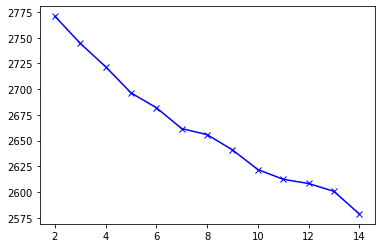

In [54]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

SSD = []
K=range(2,15)

for k in K:
    km=KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(tfidf_en_matrix)
    SSD.append(km.inertia_)

plt.plot(K, SSD, 'bx-')

Si sceglie un valore di k=5, si performa il clustering e si aggiunge l'informazione di labeling al dataframe

In [55]:
k=5

model = KMeans(n_clusters=k)
model.fit(tfidf_en_matrix)

df_en['label_kmeans']=model.labels_


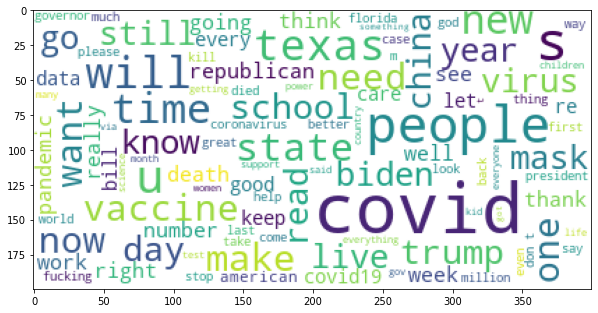

In [56]:

from wordcloud import WordCloud

df_en_0 = df_en.loc[df_en['label_kmeans']==3]
text = df_en_0['text_clean'].str.cat(sep='')
text = text.lower()
text=' '.join([word for word in text.split()])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig1 = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)